In [ ]:
import os
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from pathlib import Path
import random
from models.vqgan import GumbelVQ
from NudeNet.nudenet import nudenet
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from utils import *
from extraction import *

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")
config_path = "checkpoints/config_openimages_gumbel.yaml"
ckpt_path = "checkpoints/check_openimages_gumbel.ckpt"

# Carica configurazione
config = OmegaConf.load(config_path)

# Crea il modello
model = GumbelVQ(**config['model']['params'])

# Carica pesi
checkpoint = torch.load(ckpt_path, map_location=device)
model.load_state_dict(checkpoint["state_dict"], strict=False)

model = model.to(device).eval()

print("\nVQGAN loaded successfully!")
detector = nudenet.NudeDetector()
print("NudeNet loaded successfully!")

Using device: cpu

Working with z of shape (1, 256, 32, 32) = 262144 dimensions.


/tmp/ipykernel_8804/2035192655.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=device)



VQGAN loaded successfully!
NudeNet loaded successfully!


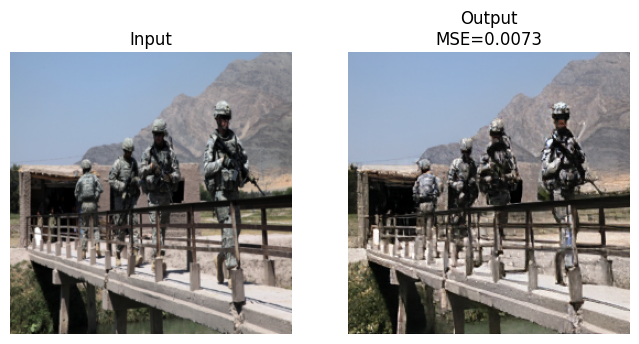

2ef8aed30c20b24b.jpg


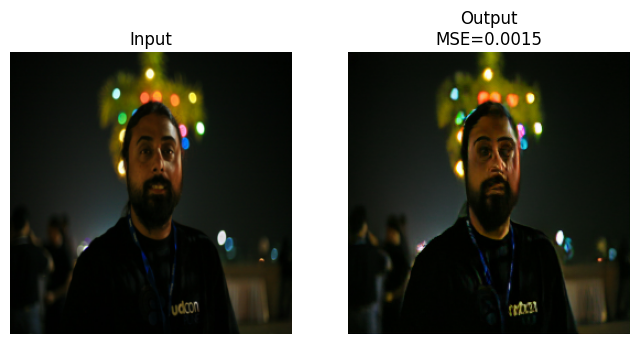

b75722d63ce76ba3.jpg


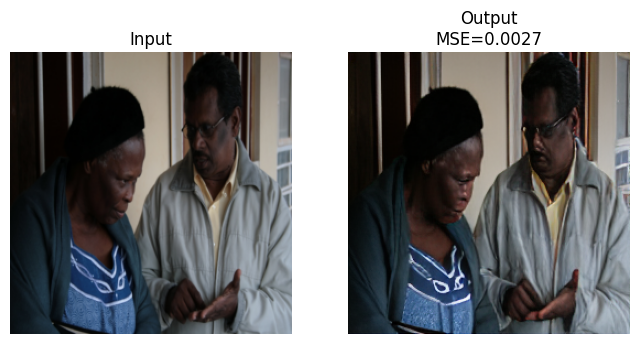

103cc4149b5a742c.jpg


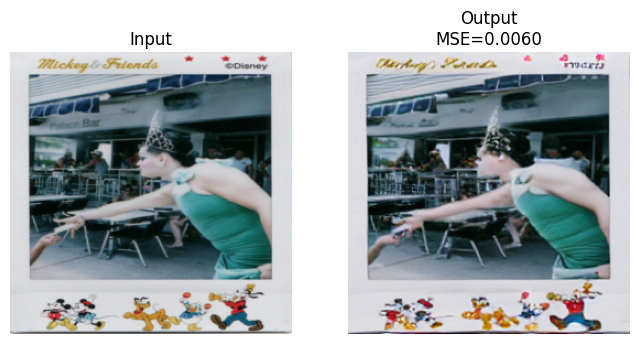

60628a0354a24323.jpg


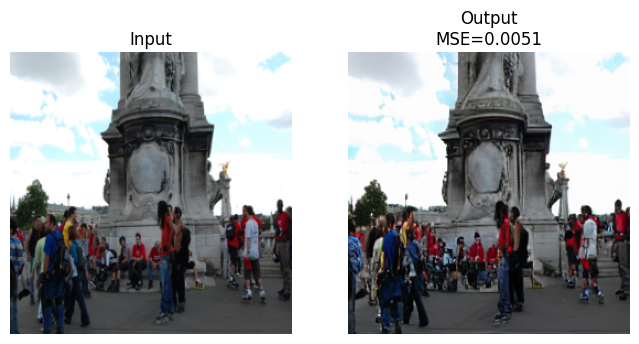

b1d94748377a70e2.jpg


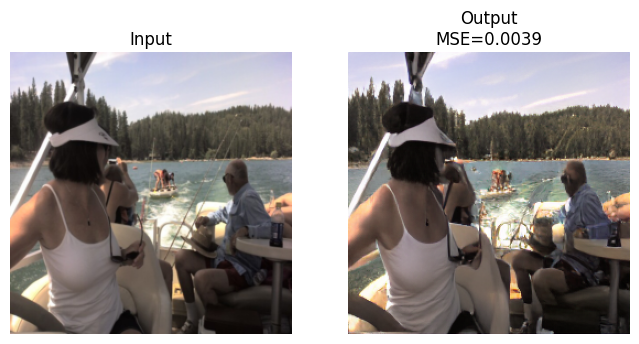

a68b9468dc7d218e.jpg


In [ ]:
transform = T.Compose([
    T.Resize((256,256)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3),
])

folder = "/home/giorgiot/fiftyone/open-images-v7/train/data"
for i, fname in enumerate(os.listdir(folder)):
    if fname.lower().endswith((".jpg",".jpeg",".png")):
        reconstruct_and_compare(os.path.join(folder, fname), model, transform)
        print(fname)
        if i>=5: break  

# Extract explicit codes 

In [ ]:
dataset_porn_train = ImageDataset(r"/media/pinas/datasets/nsfw_images_scraped/data/train/porn")
dataloader_porn_train = DataLoader(dataset_porn_train, batch_size=1, shuffle=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



index_codes_porn_train = extract_codes(model, dataloader_porn_train, device, structured=False)
torch.save(index_codes_porn_train, "index_codes_porn_train.pt")

In [ ]:
dataset_porn_test = ImageDataset(r"/media/pinas/datasets/nsfw_images_scraped/data/test/porn", image_size=256)
dataloader_porn_test = DataLoader(dataset_porn_test, batch_size=1, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



index_codes_porn_test = extract_codes(model, dataloader_porn_test, device, structured=False)
torch.save(index_codes_porn_test, "index_codes_porn_test.pt")

In [ ]:
index_codes_porn = torch.cat([index_codes_porn_test, index_codes_porn_train], dim=0)

# Retain Set on ImageNet

In [ ]:
seed = 123

torch.manual_seed(seed)
random.seed(seed)

forget_size = 60000 # Slightly increased to be divisible by 1000
num_classes = 1000  # ImageNet-1k
samples_per_class = forget_size // num_classes

retain_paths = make_balanced_subset(
    root="/media/pinas/datasets/imagenet_zeus/train",
    samples_per_class=samples_per_class,
    seed=seed
)

retain_dataset_imagenet = ImageListDataset(retain_paths)

retain_loader_imagenet = DataLoader(
    retain_dataset_imagenet,
    batch_size=1,
    shuffle=False
)

print(f'Number of images in retain set: {len(retain_dataset_imagenet)}')
print(f'Number of images per class: {samples_per_class}')

Number of images in retain set: 60000
Number of images per class: 60


In [ ]:
print(device)

index_codes_retain_imagenet = extract_codes(model, retain_loader_imagenet, device, structured=False)
torch.save(index_codes_retain_imagenet, "index_codes_retain_imagenet.pt")

print("\nFinished extracting and saving index codes for retain set!")

cuda

Finished extracting and saving index codes for retain set!


# Retain set using OpenImage (Category: Person)

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz

In [ ]:
dataset_opnimg = foz.load_zoo_dataset(
    "open-images-v7",
    split="train",
    label_types=["classifications"],
    classes = ["Person"],
    max_samples=60000,
    seed=51,
    shuffle=True,
    dataset_name="open-images-people",
)

2025-12-07  19:48:11 INFO Downloading split 'train' to '/home/giorgiot/fiftyone/open-images-v7/train' if necessary


2025-12-07  19:48:11 INFO Downloading 'https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv' to '/home/giorgiot/fiftyone/open-images-v7/train/metadata/image_ids.csv'


 100% |██████|    4.8Gb/4.8Gb [38.6s elapsed, 0s remaining, 140.0Mb/s]      


2025-12-07  19:48:50 INFO  100% |██████|    4.8Gb/4.8Gb [38.6s elapsed, 0s remaining, 140.0Mb/s]      


2025-12-07  19:49:03 INFO Downloading 'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv' to '/home/giorgiot/fiftyone/open-images-v7/train/metadata/classes.csv'


2025-12-07  19:49:04 INFO Downloading 'https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy.json' to '/tmp/tmpml_r8e2i/metadata/hierarchy.json'


2025-12-07  19:49:04 INFO Downloading 'https://storage.googleapis.com/openimages/v5/train-annotations-human-imagelabels-boxable.csv' to '/home/giorgiot/fiftyone/open-images-v7/train/labels/classifications.csv'


2025-12-07  19:50:02 INFO Downloading 60000 images


 100% |███████████████| 60000/60000 [43.7m elapsed, 0s remaining, 18.5 files/s]      


2025-12-07  20:33:43 INFO  100% |███████████████| 60000/60000 [43.7m elapsed, 0s remaining, 18.5 files/s]      


Dataset info written to '/home/giorgiot/fiftyone/open-images-v7/info.json'


2025-12-07  20:33:44 INFO Dataset info written to '/home/giorgiot/fiftyone/open-images-v7/info.json'
***Python 3.8 Deprecation Notice***
Python 3.8 will no longer be supported in new releases after October 1, 2024.
Please upgrade to Python 3.9 or later.
For additional details please see https://deprecation.voxel51.com


Loading 'open-images-v7' split 'train'


2025-12-07  20:33:47 INFO Loading 'open-images-v7' split 'train'


 100% |█████████████| 60000/60000 [3.1m elapsed, 0s remaining, 338.9 samples/s]      


2025-12-07  20:37:04 INFO  100% |█████████████| 60000/60000 [3.1m elapsed, 0s remaining, 338.9 samples/s]      


Dataset 'open-images-people' created


2025-12-07  20:37:04 INFO Dataset 'open-images-people' created


In [ ]:
dataset_retain_openimg = ImageDataset(r"/home/giorgiot/fiftyone/open-images-v7/train/data", image_size=256)
dataloader_retain_openimg = DataLoader(dataset_retain_openimg, batch_size=1, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



index_codes_openimage = extract_codes(model, dataloader_retain_openimg, device, structured=False)
torch.save(index_codes_openimage, "index_codes_retain_person.pt")

# Retain set using clothes folders of ImageNet

In [ ]:
paths_for_retain = collect_image_paths(
    [r"/media/pinas/datasets/imagenet_zeus/train/n02837789", r'/media/pinas/datasets/imagenet_zeus/val/n02837789',
     r'/media/pinas/datasets/imagenet_zeus/train/n03770439', r'/media/pinas/datasets/imagenet_zeus/val/n03770439',
     r'/media/pinas/datasets/imagenet_zeus/train/n04350905', r'/media/pinas/datasets/imagenet_zeus/val/n04350905',
     r'/media/pinas/datasets/imagenet_zeus/train/n04370456', r'/media/pinas/datasets/imagenet_zeus/val/n04370456'])
dataset_retain_bikini = ImageListDataset(paths_for_retain, image_size=256)
dataloader_retain_bikini = DataLoader(dataset_retain_bikini, batch_size=1, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



index_codes_retain_bikini = extract_codes(model, dataloader_retain_bikini, device, structured=False)
torch.save(index_codes_retain_bikini, "index_codes_retain_bikini.pt")

# Retain set using masked explicit images (only for breasts)

In [ ]:
masked_explicit_dataset = ImageDataset("/media/pinas/datasets/nsfw_images_scraped/data/train/porn/")
masked_explicit_dataloader = DataLoader(masked_explicit_dataset, batch_size=1, shuffle=False)

In [ ]:
target_classes = ['FEMALE_BREAST_EXPOSED']
index_codes_mask, _ = extract_codes_nudenet(model, detector, masked_explicit_dataloader, target_classes, expand=0.3, mask_breasts=True)
torch.save(index_codes_mask, "index_codes_masked_breasts.pt")


EXTRACTING CODES (Strategy: masked, Occlusion: True)...
  Processed 10 batches (4 items)...
  Processed 20 batches (10 items)...
  Processed 30 batches (13 items)...
  Processed 40 batches (17 items)...
  Processed 50 batches (22 items)...
  Processed 60 batches (30 items)...
  Processed 70 batches (34 items)...
  Processed 80 batches (42 items)...
  Processed 90 batches (45 items)...
  Processed 100 batches (48 items)...
  Processed 110 batches (50 items)...
  Processed 120 batches (55 items)...
  Processed 130 batches (59 items)...
  Processed 140 batches (61 items)...
  Processed 150 batches (65 items)...
  Processed 160 batches (70 items)...
  Processed 170 batches (72 items)...
  Processed 180 batches (78 items)...
  Processed 190 batches (83 items)...
  Processed 200 batches (88 items)...
  Processed 210 batches (90 items)...
  Processed 220 batches (94 items)...
  Processed 230 batches (95 items)...
  Processed 240 batches (97 items)...
  Processed 250 batches (100 items)...
  

# Retain set using masked explicit images (all explicit contents)

In [ ]:
target_classes = ['BUTTOCKS_EXPOSED', 'FEMALE_BREAST_EXPOSED', 'FEMALE_GENITALIA_EXPOSED', 'ANUS_EXPOSED', 'MALE_GENITALIA_EXPOSED']
index_codes_mask_total, _ = extract_codes_nudenet(model, detector, masked_explicit_dataloader, target_classes, mask_breasts=True)
torch.save(index_codes_mask_total, "index_codes_masked_total.pt")


EXTRACTING CODES (Strategy: masked, Occlusion: True)...
  Processed 10 batches (7 items)...
  Processed 20 batches (14 items)...
  Processed 30 batches (21 items)...
  Processed 40 batches (30 items)...
  Processed 50 batches (39 items)...
  Processed 60 batches (49 items)...
  Processed 70 batches (54 items)...
  Processed 80 batches (62 items)...
  Processed 90 batches (67 items)...
  Processed 100 batches (72 items)...
  Processed 110 batches (80 items)...
  Processed 120 batches (88 items)...
  Processed 130 batches (92 items)...
  Processed 140 batches (98 items)...
  Processed 150 batches (105 items)...
  Processed 160 batches (112 items)...
  Processed 170 batches (119 items)...
  Processed 180 batches (126 items)...
  Processed 190 batches (136 items)...
  Processed 200 batches (142 items)...
  Processed 210 batches (146 items)...
  Processed 220 batches (153 items)...
  Processed 230 batches (159 items)...
  Processed 240 batches (165 items)...
  Processed 250 batches (172 it